In [53]:
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoModel, BertTokenizerFast
import torch
import torch.nn as nn
import time
from sklearn.metrics import classification_report
pd.set_option('display.max_colwidth', 110000)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
Device name: Tesla T4


In [54]:
print(torch.version.cuda)

11.8


In [55]:
# hyper-parameters
freezing_all = False # true if not retraing BERT false if retraining
n_frozen_layers_bert = 8
batch_size = 32
max_seq_len = 100
dropout_proportion = 0.5
epochs = 10
learning_rate = 3e-5

In [56]:
df = pd.read_csv("text-no-emoji_labeled.csv",index_col=0)
df['text'] = df['text'].astype(str)
df.tail()

,text,label,assunto_1,assunto_2
1396903474135277569,kelly key defensora do sus tomando vacina eu te amo,0,NaN,NaN
1396903283223109642,"oi, família! ^coração_azul$ ^cobra$ quem aqui já tomou a primeira dose da vacina contra a covid-19?",0,NaN,NaN
1396903270543773697,minha mãe tomou a primeira dose da vacina ^face_sorridente_com_corações$,0,NaN,NaN
1396902592219844609,barroso: prefeito recebe a 1a dose da vacina contra a covid-19,0,NaN,NaN
1396900766162604036,estudo aponta que vacina russa é altamente efetiva contra variante brasileira da covid,1,saude,NaN


In [57]:
df['assunto_1'] = df['assunto_1'].str.lower()
df['assunto_1'] = df['assunto_1'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df['assunto_2'] = df['assunto_2'].str.lower()
df['assunto_2'] = df['assunto_2'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
#df['assunto_1'].value_counts()

In [58]:
df['label'].value_counts()

0    12860
1     1562
Name: label, dtype: int64

In [59]:
# Removing ironic and humorous tweets
df = df[df['assunto_1'] != 'ironia']
df = df[df['assunto_2'] != 'ironia']
df = df[df['assunto_1'] != 'humor']
df = df[df['assunto_2'] != 'humor']
df['label'].value_counts()

0    12856
1     1144
Name: label, dtype: int64

In [60]:
# to improve the results it is necessary to balance the database
seed = random.randrange(10000)
true = df[df['label'] == 0].sample(2000, random_state=seed) #best result seed 10
fake = df[df['label'] == 1]
df = pd.concat([true,fake]).sample(frac=1, random_state=seed)
print(seed)
df['label'].value_counts(normalize=True)

0    0.636132
1    0.363868
Name: label, dtype: float64

In [61]:
df['label'].value_counts()

0    2000
1    1144
Name: label, dtype: int64

In [62]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [63]:
test_text.shape

(472,)

In [64]:
train_labels.value_counts()

0    1399
1     801
Name: label, dtype: int64

In [65]:
val_labels.value_counts()

0    300
1    172
Name: label, dtype: int64

In [66]:
test_labels.value_counts()

0    301
1    171
Name: label, dtype: int64

In [67]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)

# Custom tokens
new_tokens = ['vacina', 'bolsonaro','jair','brasil','covid','vacinação','pfizer','doria','cloroquina','ivermectina']
tokenizer.add_tokens(new_tokens)

bert.resize_token_embeddings(len(tokenizer))

Embedding(29803, 768)

In [68]:
#checking
tokenizer.tokenize('saúde')

['saúde']

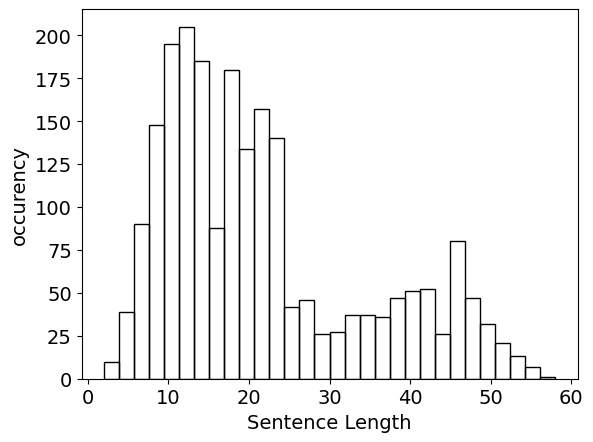

In [69]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).drop(1456).hist(bins = 30,facecolor='none',edgecolor='black');
plt.xlabel('Sentence Length',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('occurency',fontsize=14)
plt.grid(False)

In [70]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

In [71]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

In [72]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [73]:
# freezing or unfreezing BERT
if freezing_all == True:
    # freeze all the parameters
    for param in bert.parameters():
      param.requires_grad = False
elif freezing_all == False:
    # freeze some the parameters
    modules = [bert.embeddings, *bert.encoder.layer[:n_frozen_layers_bert]] # <= n = number of initial frozen layers
    for module in modules:
        for param in module.parameters():
            param.requires_grad = False
else:
    raise ValueError('Freezing not specified.')

In [75]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(dropout_proportion)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer input
      self.fc1 = nn.Linear(768,512)

      # dense layer output (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [76]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [77]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_labels), y = train_labels)

print(class_wts)

[0.78627591 1.3732834 ]


In [78]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights)

In [79]:
# optimizer from hugging face transformers
from transformers import AdamW
#from torch.optim import Adam

# define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)

In [80]:
# function to train the model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]


    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [81]:
# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:


      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)


  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

# #for each epoch
for epoch in range(epochs):
    #break

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _  = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print('new best valid at:',epoch+1)
        best = epoch+1
        torch.save(model.state_dict(), 'saved_weights_test.pt') #<= best is saved_weights.pt

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)


    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
print('best epoch:',best)


 Epoch 1 / 10


In [ ]:
import matplotlib.pyplot as plt
x = range(1, len(train_losses)+1)
y1 = train_losses
y2 = valid_losses
plt.figure(figsize=(12,8))
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Evaluation",fontsize=20)
plt.plot(x,y1,label = 'Train Loss')
plt.plot(x,y2,label = 'Valid Loss')
plt.ylim(0,1)
plt.grid(True)
plt.legend(loc='best',fontsize=16);

In [ ]:
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

In [ ]:
# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
#load weights of best model
path = 'saved_weights_test.pt'
model.load_state_dict(torch.load(path,map_location=torch.device('cpu')))

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
roc_prob = preds
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds,digits=4))

In [ ]:
# confusion matrix
# 1 fake
# 0 true
tab = pd.crosstab(test_y, preds, rownames=['Actual'], colnames=['Predicted'],margins=True)
tab

In [ ]:
print('True Positives (TP):',tab[0].iloc[0])
print('True Negatives (TN):',tab[1].iloc[1])
print('False Positives (FP):',tab[1].iloc[0])
print('False Negatives (FN):',tab[0].iloc[1],'  <-this is the worst case for us')

In [ ]:
tp = tab[0].iloc[0]
tn = tab[1].iloc[1]
fp = tab[1].iloc[0]
fn = tab[0].iloc[1]
recall = tp/(tp+fn)
precision = tp/(tp+fp)
accuracy = (tp+tn)/(tp+fp+fn+tn)
f1= 2*(recall * precision) / (recall + precision)

print('Accuracy: {0:.3f}'.format(accuracy))
print('Precision: {0:.3f}'.format(precision))
print('Recall: {0:.3f}'.format(recall))
print('F1: {0:.3f}'.format(f1))

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar().ax.tick_params(labelsize=16)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names,fontsize=16)
        plt.yticks(tick_marks, target_names,fontsize=16)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),fontsize=24,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]), fontsize=24,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label',fontsize=16)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass),fontsize=16)
    plt.show()

In [ ]:
plot_confusion_matrix(cm           = np.array(tab.iloc[0:2, 0:2]),
                      normalize    = False,
                      target_names = ['True News', 'Fake News'],
                      title        = "")

In [ ]:
temp = np.e**roc_prob
prob = []
for item in temp:
    prob.append(item.max())

In [ ]:
probb = []
for i in range(len(prob)):
    if prob[i] > 0.5:
        probb.append(1)
    else:
        probb.append(0)

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(test_y, prob,pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 1.5

plt.figure(figsize=(8, 6))
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate",fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.title("Receiver Operating Characteristic Logistic Regression",fontsize=20)
plt.legend(loc="lower right",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True);

In [ ]:
check = pd.DataFrame(list(zip(test_text, test_y.numpy(),preds)),
               columns =['text', 'label','pred_label'])
# 1 means Fake and 0 means the message is not a Fake.
check[check['label'] != check['pred_label']].sample(n=10)